We will use the daily spreadsheet from EU CDC containing new cases and deaths per country per day.

In [1]:
!wget -N https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

--2020-09-18 16:27:30--  https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx
Resolving www.ecdc.europa.eu (www.ecdc.europa.eu)... 13.227.219.122, 13.227.219.10, 13.227.219.21, ...
Connecting to www.ecdc.europa.eu (www.ecdc.europa.eu)|13.227.219.122|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘COVID-19-geographic-disbtribution-worldwide.xlsx’ not modified on server. Omitting download.



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [2]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork')

%matplotlib inline

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [3]:
df = pd.read_excel('COVID-19-geographic-disbtribution-worldwide.xlsx', keep_default_na=False, na_values='')
df.head(10)

dateRep  day  month  year  cases  deaths countriesAndTerritories geoId  \
0 2020-09-18   18      9  2020      0       0             Afghanistan    AF   
1 2020-09-17   17      9  2020     17       0             Afghanistan    AF   
2 2020-09-16   16      9  2020     40      10             Afghanistan    AF   
3 2020-09-15   15      9  2020     99       6             Afghanistan    AF   
4 2020-09-14   14      9  2020     75       0             Afghanistan    AF   
5 2020-09-13   13      9  2020     35       0             Afghanistan    AF   
6 2020-09-12   12      9  2020     34       0             Afghanistan    AF   
7 2020-09-11   11      9  2020     28       0             Afghanistan    AF   
8 2020-09-10   10      9  2020     24       2             Afghanistan    AF   
9 2020-09-09    9      9  2020     26       3             Afghanistan    AF   

  countryterritoryCode  popData2019 continentExp  \
0                  AFG   38041757.0         Asia   
1                  AFG   38041757.0         Asia   
2                  AFG   38041757.0         Asia   
3                  AFG   38041757.0         Asia   
4                  AFG   38041757.0         Asia   
5                  AFG   38041757.0         Asia   
6                  AFG   38041757.0         Asia   
7                  AFG   38041757.0         Asia   
8                  AFG   38041757.0         Asia   
9                  AFG   38041757.0         Asia   

   Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
0                                           1.535155           
1                                           1.653446           
2                                           1.708649           
3                                           1.627159           
4                                           1.456294           
5                                           1.309088           
6                                           1.224970           
7                                           1.164510           
8                                           1.098793           
9                                           1.180282

Last check of our source dataframe.

In [4]:
df.count()

dateRep                                                       43509
day                                                           43509
month                                                         43509
year                                                          43509
cases                                                         43509
deaths                                                        43509
countriesAndTerritories                                       43509
geoId                                                         43509
countryterritoryCode                                          43445
popData2019                                                   43445
continentExp                                                  43509
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000    40728
dtype: int64

We pivot to a country by column format.

In [5]:
df_geo = df.pivot_table(index='dateRep', columns='year', values=['cases', 'deaths'], aggfunc='sum')
df_geo

cases           deaths        
year        2019      2020   2019    2020
dateRep                                  
2019-12-31  27.0       NaN    0.0     NaN
2020-01-01   NaN       0.0    NaN     0.0
2020-01-02   NaN       0.0    NaN     0.0
2020-01-03   NaN      17.0    NaN     0.0
2020-01-04   NaN       0.0    NaN     0.0
...          ...       ...    ...     ...
2020-09-14   NaN  272588.0    NaN  3880.0
2020-09-15   NaN  242771.0    NaN  4234.0
2020-09-16   NaN  303470.0    NaN  6956.0
2020-09-17   NaN  290172.0    NaN  5435.0
2020-09-18   NaN  298380.0    NaN  5207.0

[263 rows x 4 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [6]:
new_index = pd.date_range(df_geo.index.min(), df_geo.index.max() + pd.Timedelta('365 days'))
df_geo = df_geo.reindex(new_index)
df_geo

cases       deaths     
year        2019  2020   2019 2020
2019-12-31  27.0   NaN    0.0  NaN
2020-01-01   NaN   0.0    NaN  0.0
2020-01-02   NaN   0.0    NaN  0.0
2020-01-03   NaN  17.0    NaN  0.0
2020-01-04   NaN   0.0    NaN  0.0
...          ...   ...    ...  ...
2021-09-14   NaN   NaN    NaN  NaN
2021-09-15   NaN   NaN    NaN  NaN
2021-09-16   NaN   NaN    NaN  NaN
2021-09-17   NaN   NaN    NaN  NaN
2021-09-18   NaN   NaN    NaN  NaN

[628 rows x 4 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [7]:
df_geo['daynum'] = (df_geo.index - df_geo.index.min()).days
df_geo['daynum'].describe()

count    628.000000
mean     313.500000
std      181.432265
min        0.000000
25%      156.750000
50%      313.500000
75%      470.250000
max      627.000000
Name: daynum, dtype: float64

We create a simple dataframe to contain the source values for our fitting approach. The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`. The measures are averaged by week to smooth out reporting lags.

In [8]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

In [9]:
country  = 2020
measure  = 'cases'
smeasure = 'scases' # smoothed
rmeasure = 'rcases' # remaining
pmeasure = 'pcases' # predicted
wmeasure = 'wcases' # waves

wave = 0

df_geo[(pmeasure, country)] = 0
df_geo[(smeasure, country)] = df_geo[measure][country].loc[:].rolling(7).mean()
df_geo[(rmeasure, country)] = df_geo[smeasure][country]

plotlist = [(smeasure, country), (pmeasure, country)]

In [10]:
#countryname = df[df['geoId'] == country]['countriesAndTerritories'].iloc[0]
#popdata = df[df['geoId'] == country]['popData2019'].iloc[0]

#mincases = popdata / 1e6
mincases = 2
#mincases = df_geo[smeasure][country].sum() / 5000

wcases0 beta  4.487 with mu  43 from  49 to  56 for 78553
wcases1 beta  9.243 with mu  35 from  25 to  37 for 34381
wcases2 beta 17.957 with mu 104 from  77 to 113 for 3928282
wcases3 beta  2.075 with mu  96 from  96 to  99 for 14077
wcases4 beta  5.517 with mu 122 from 117 to 121 for 300486
wcases5 beta  7.262 with mu 134 from 127 to 133 for 780287
wcases6 beta  6.817 with mu 145 from 139 to 143 for 862744
wcases7 beta  8.336 with mu 157 from 149 to 155 for 1513032
wcases8 beta  5.412 with mu 163 from 159 to 163 for 634517
wcases9 beta  6.431 with mu 174 from 167 to 173 for 1528517
wcases10 beta  5.452 with mu 182 from 177 to 181 for 1250343
wcases11 beta  4.931 with mu 189 from 185 to 189 for 1438688
wcases12 beta  4.706 with mu 197 from 193 to 197 for 1655916
wcases13 beta  9.930 with mu 213 from 203 to 219 for 6896339
wcases14 beta  7.859 with mu 232 from 225 to 235 for 3723774
wcases15 beta  6.578 with mu 245 from 239 to 245 for 2554986
wcases16 beta  8.918 with mu 260 from 249 to

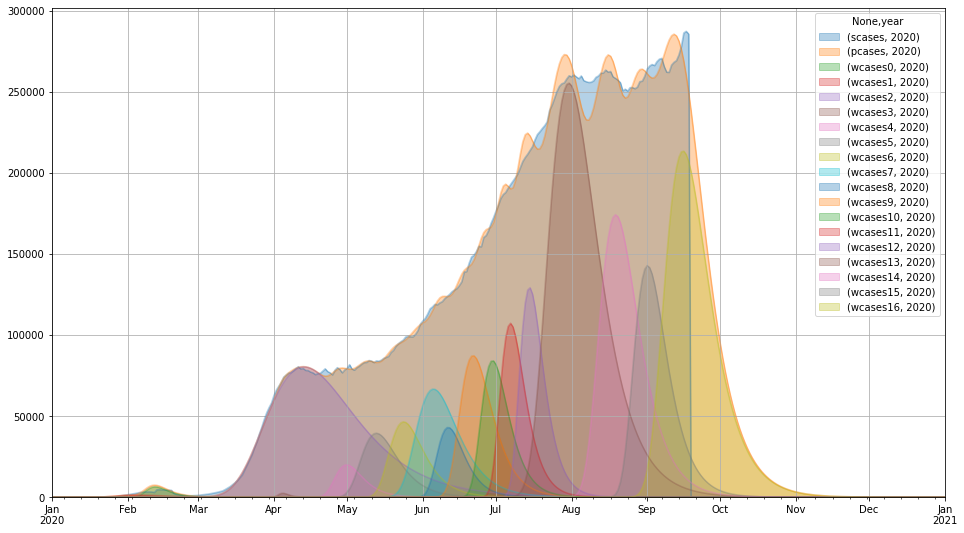

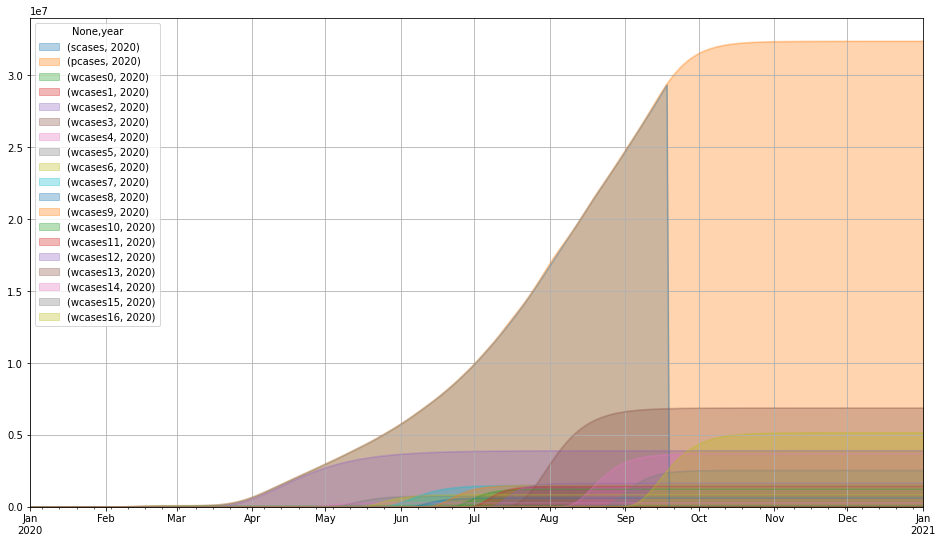

In [11]:
#print('Running multiple wave analysis for {} with population {:1.0f}'.format(countryname, popdata))
#print('Minimum number of cases is {:1.0f}'.format(mincases))

while True:
    #print('Analyzing wave {:1.0f}'.format(wave))
    curwave = wmeasure + str(wave)
    df_geo[(curwave, country)] = 0

    df_pred = pd.DataFrame({'daynum':df_geo['daynum'],
                            measure:df_geo[rmeasure][country]})
    #df_pred[df_pred[measure].notnull()].plot(x='daynum', y=measure, figsize=(16, 9), grid=True)

    df_pred['gumdiv'] = df_pred[measure] / df_pred[measure].cumsum()
    df_pred = df_pred[(df_pred['gumdiv'] > 0) & (df_pred[measure] > mincases)]

    df_pred['linear'] = np.log(df_pred['gumdiv'])

    df_pred = df_pred[(df_pred['linear'] < -0.5) &
                      (df_pred['linear'] > -4.5)]

    #df_pred['linear'].plot(figsize=(16, 9), grid=True)
    
    if len(df_pred) <= 1:
        break

    X = df_pred['daynum'].values.reshape(-1, 1)
    y = df_pred['linear'].values.reshape(-1, 1)

    #model = Earth(minspan=0)
    model = Earth(minspan=1, penalty=0, endspan=0, thresh=1e-9, check_every=1)
    model.fit(X, y)

    #print(model.trace())
    #print(model.summary())

    df_pred['earth'] = model.predict(X)

    daymin = df_pred['daynum'].min()
    daymax = df_pred['daynum'].max()
    #print('From {} to {}'.format(daymin, daymax))

    #df_pred.plot(x='daynum', y=['linear', 'earth'], figsize=(16, 9), grid=True)

    #df_pred['gbgrad'] = np.gradient(df_pred['linear'])
    #df_pred['eagrad'] = np.gradient(df_pred['earth'])
    df_pred['gbgrad'] = df_pred['linear'] - df_pred['linear'].shift(1)
    df_pred['eagrad'] = df_pred['earth'] - df_pred['earth'].shift(1)

    #df_pred['gbgrad'] = df_pred['linear'] - df_pred['linear'].shift(1)
    #df_pred['eagrad'] = df_pred['earth'] - df_pred['earth'].shift(1)

    #df_pred.plot(x='daynum', y=['gbgrad', 'eagrad'], figsize=(16, 9), grid=True)

    fitmod = export.export_python_function(model)
    #print(export.export_python_string(model))

    df_pred['knot'] = ((abs(df_pred['eagrad'] - df_pred['eagrad'].shift(1)) > 1e-6) |
                       (df_pred['daynum'] == (daymin + 1)) |
                       (df_pred['daynum'] == daymax))
    df_pred['daycount'] = df_pred.reset_index().index
    #df_pred[df_pred['knot']]

    df_knot = df_pred[df_pred['knot']][['daynum', 'daycount', 'eagrad']]
    df_knot['days'] = df_knot['daycount'].shift(-1) - df_knot['daycount']
    #df_knot = df_knot[(df_knot['days'] >= 5)]
    #df_knot['eadiff'] = df_knot['eagrad'] - df_knot['eagrad'].shift(1)
    #df_knot

    df_knot['cand'] = ((df_knot['eagrad'] < -1/30) &
                       (df_knot['days'] >= 3))
    #df_knot

    df_knot['since'] = df_knot['daynum'] - daymin
    
    #df_knot['score'] = - df_knot['eagrad']
    #df_knot['score'] = (df_knot['eagrad'] ** 2) * df_knot['days'] / np.sqrt(df_knot['since'])
    df_knot['score'] = (df_knot['eagrad'] ** 2) * np.sqrt(df_knot['days'] / np.sqrt(df_knot['since']))

    df_knot['choice'] = df_knot['score'] == df_knot[df_knot['cand']]['score'].max()
    #df_knot

    choice = df_knot[df_knot['choice']]
    if len(choice) == 0:
        break
    
    lower = choice['daynum'].values[0]
    upper = choice['days'].values[0] + lower
    #print('From {} to {}'.format(lower, upper))

    #lower = 185
    #upper = 187

    df_pred = df_pred[(df_pred['daynum'] >= lower) &
                      (df_pred['daynum'] <= upper)].copy()

    slope = (fitmod([[upper]])[0] - fitmod([[lower]])[0]) / (upper - lower)
    intercept = fitmod([[lower]])[0] - (lower * slope)

    #print('From {} to {} with slope {:1.4f} and intercept {:1.3f}'.format(
    #    lower, upper, slope, intercept))

    beta = - 1 / slope
    mu = beta * (intercept + np.log(beta))

    df_pred['pgumb'] = gumpdf(df_pred['daynum'], beta, mu)
    df_pred['scale'] = df_pred[measure] / df_pred['pgumb']

    final = df_pred['scale'].mean()

    print('{} beta {:6.3f} with mu {:3.0f} from {:3.0f} to {:3.0f} for {:1.0f}'.format(
        curwave, beta, mu, lower, upper, final))

    df_geo[(curwave, country)] = final * gumpdf(df_geo['daynum'], beta, mu)
    df_geo[(pmeasure, country)] += df_geo[(curwave, country)]
    df_geo[(rmeasure, country)] -= df_geo[(curwave, country)]
    plotlist += [(curwave, country)]
    wave += 1

df_geo[plotlist].loc['20200101':'20210101'].plot(
    figsize=(16, 9), grid=True, kind='area', stacked=False, alpha=1/3)

df_geo[plotlist].loc['20200101':'20210101'].cumsum().plot(
    figsize=(16, 9), grid=True, kind='area', stacked=False, alpha=1/3)

We have the estimate for the final number of cases, so the progress would be the current number of cases divided by the final number. This could end up over 100%, if we estimate that the current wave of the outbreak is over and new cases are due to relaxing of measures, increase in testing or other factors.

In [12]:
progress = df_geo[measure][country].sum() / df_geo[pmeasure][country].sum()
print('Currently at {:1.2f}% of {:1.0f}'.format(progress * 100, df_geo[pmeasure][country].sum()))

Currently at 93.33% of 32374406


The peak can be found at the first predicted value that is larger than the next.

In [13]:
peak = df_geo[df_geo[(pmeasure, country)] == df_geo[(pmeasure, country)].max()].index.min()
print('Peak at {}'.format(peak.date()))

Peak at 2020-09-12


This date should closely match the `mu` of our distribution, in days since the start of the index.

In [14]:
print('Peak by last mu at {}'.format(df_geo.loc[df_geo['daynum'] == mu.astype(int)].index[0].date()))

Peak by last mu at 2020-09-15


The floor is defined as the first time that the number of reported cases falls below 1 in a million, which is the first time that happens *after* the peak.

In [15]:
floor = df_geo[(df_geo[(pmeasure, country)] < (popdata / 1e6)) &
               (df_geo[(pmeasure, country)].index > peak)].index.min()
print('Floor at {}'.format(floor.date()))

NameError: name 'popdata' is not defined

Similarly, we can calculate the start as the first day where the number of cases was above 1 in a million before the peak.

In [ ]:
start = df_geo[(df_geo[(pmeasure, country)] > (popdata / 1e6)) &
               (df_geo[(pmeasure, country)].index < peak)].index.min()
print('Start at {}'.format(start.date()))

We define the maximum delta as the day in the curve with the sharpest rise.

In [ ]:
maxrise = (df_geo[(pmeasure, country)] - df_geo[(pmeasure, country)].shift()).max()
maxdelta = df_geo[(df_geo[(pmeasure, country)] - df_geo[(pmeasure, country)].shift()) == (
    maxrise)].index.min()
print('Largest rise of {:1.0f} on {}'.format(maxrise, maxdelta.date()))

This should match the maximum gradient of the daily data.

In [ ]:
print('Maximum gradient is {:1.0f}'.format(np.gradient(df_geo[(pmeasure, country)]).max()))

Back to the original curve, showing the number of infected concurrently.

In [ ]:
df_geo[pmeasure][country].rolling(14).sum().loc[start:floor].plot()

The top of this curve gives the maximum number of people that are infected at the same time.

In [ ]:
print('Maximum infected is {:1.0f}'.format(df_geo[pmeasure][country].rolling(14).sum().max()))

If we look at the difference between our actual (smoothed) value and our prediction, we can clearly see if the curve is breaking out after the floor. This can be the result of relaxing of measures and the beginning of a second wave, an increase in testing or other factors.

In [ ]:
(df_geo[(smeasure, country)] - df_geo[(pmeasure, country)]).loc[:].plot()

Keep exploring! Stay home, wash your hands, keep your distance.